In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import imageio
import os
from numba import njit
from timeit import default_timer as timer
from datetime import datetime
import sys
from scipy import stats

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "rmfamily"
    })
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams["figure.autolayout"] = True

In [2]:
# aa_is_PHO=[]
# with open("../example_input_files/aapot_water.dat", 'r') as f:
#     for line in f:
#         if line.strip()=='0':
#             aa_is_PHO.append(1)
#         else:
#             aa_is_PHO.append(0)
# aa_is_PHO=aa_is_PHO[:20]
# for ii,now_is_pho in enumerate(aa_is_PHO):
#     if now_is_pho:
#         print(ii,aa_order[ii])

In [3]:
aa_order="ACDEFGHIKLMNPQRSTVWY"
aa_is_PHO=[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
letter_to_number_map = {letter: -(index+1) for index, letter in enumerate(aa_order)}


def convert_raw_conf_data(raw_conf_data,n_proteins,n_monomers):
    raw_t_data=raw_conf_data[:,0]
    raw_x_data=raw_conf_data[:,1]
    raw_y_data=raw_conf_data[:,2]

    list_of_times=np.unique(raw_t_data)
    t_i=list_of_times[0]
    t_f=list_of_times[-1]
    d_t=list_of_times[1]-list_of_times[0]

    n_snapshots=list_of_times.size
    x_pos=np.empty([n_monomers, n_proteins, n_snapshots],dtype=np.int32)
    y_pos=np.empty([n_monomers, n_proteins, n_snapshots],dtype=np.int32)

    for i_t in range(n_snapshots):
        now_t_indexes=(raw_t_data==list_of_times[i_t])
        now_x=raw_x_data[now_t_indexes]
        now_y=raw_y_data[now_t_indexes]
        for i_prot in range(n_proteins):
            now_prot_indexes = np.arange(0,n_monomers) + i_prot*n_monomers
            x_pos[:,i_prot,i_t]=now_x[now_prot_indexes]
            y_pos[:,i_prot,i_t]=now_y[now_prot_indexes]
    return x_pos,y_pos,list_of_times

In [4]:
AB42="DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA"

box_size=50
temperature=0.3
pressure=0.0007
n_proteins=1
n_running_steps=int(1e4)
save_every=n_running_steps//100

aa_sequence_in_numbers=[letter_to_number_map[ii] for ii in AB42]
n_monomers=len(aa_sequence_in_numbers)


path_working_directory="../working_directory/"
# os.system(f"rm -rf {path_working_directory:}/*")
os.system(f"cp ../fortran_source_code/MC_hydrated_proteins.exe {path_working_directory:}/MC_hydrated_proteins.exe")
os.system(f"cp ../example_input_files/aapot_water.dat {path_working_directory:}/aapot_water.dat")
os.system(f"cp ../example_input_files/water_parameters {path_working_directory:}/water_parameters")


# write file "input_data_folding"
now_file=f"{path_working_directory:}/input_data_folding"
now_lines=f"""\
Box_Size		{box_size:}
Temperature		{temperature:}
Pressure		{pressure:}
Number_Proteins		{n_proteins:}
Equilibration_Steps	0
Running_Steps		{n_running_steps:}
Sampling_Data_Time	{save_every:}
Sampling_Conf_Time	{save_every:}
Seed			0
Number_Species		1
Flux			0
"""
with open(now_file, 'w') as f:
    f.write(now_lines)


# write file "input_sequences.dat"
now_file=f"{path_working_directory:}/input_sequences.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        for i_monomer in range(n_monomers):
            f.write(f"{i_monomer+1:4d} {aa_sequence_in_numbers[i_monomer]:4d}\n")

# write file "input_sequences.dat"
now_file=f"{path_working_directory:}/input_sequences.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        for i_monomer in range(n_monomers):
            f.write(f"{i_monomer+1:4d} {aa_sequence_in_numbers[i_monomer]:4d}\n")

# write file "protein_lengths.dat"
now_file=f"{path_working_directory:}/protein_lengths.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        f.write(f"{n_monomers:4d}\n")

# write file "protein_species.dat"
now_file=f"{path_working_directory:}/protein_species.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        f.write(f"{1:4d}\n")

# write file "protein_moves.dat"
now_file=f"{path_working_directory:}/protein_moves.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        f.write(f"{1:4d}\n")

# write file "target_structures.dat"
now_file=f"{path_working_directory:}/target_structures.dat"
with open(now_file, 'w') as f:
    for i_prot in range(n_proteins):
        for i_monomer in range(n_monomers):
            f.write(f"{1:4d} {1:4d}\n")


In [5]:
os.system(f"cd {path_working_directory:};./MC_hydrated_proteins.exe {np.random.randint(1000,1000000000)}")

 Found the files Final_Configuration.dat and Final_Protein_Conformation.dat of the previous simulation.
 The new run will continue from such files.


0

In [6]:
final_prot_conf=np.loadtxt(f"{path_working_directory:}/Final_Protein_Conformation.dat",dtype=np.int32)
final_syst_config=np.loadtxt(f"{path_working_directory:}/Final_Configuration.dat",dtype=np.int32)



trans_x=0
trans_y=0
final_prot_conf[:,0]=(final_prot_conf[:,0]-1+trans_x)%box_size+1
final_prot_conf[:,1]=(final_prot_conf[:,1]-1+trans_y)%box_size+1

final_syst_config[:,0]=(final_syst_config[:,0]-1+trans_x)%box_size+1
final_syst_config[:,1]=(final_syst_config[:,1]-1+trans_y)%box_size+1

np.savetxt(f"{path_working_directory:}/Final_Protein_Conformation.dat",final_prot_conf,fmt='%7d')
np.savetxt(f"{path_working_directory:}/Final_Configuration.dat",final_syst_config,fmt='%7d')




In [7]:
def plot_HB(ax,hor_HB,ver_HB,rx,ry):
    regular_HB_width=.8
    spec_HB_width=.8
    for i_site in range(np.size(hor_HB)):
        if (hor_HB[i_site]==1):
            ax.plot(rx[i_site]+[0,1],ry[i_site]+[0,0],'-k',markersize=.5,linewidth=regular_HB_width)
        elif (hor_HB[i_site]==2):
            ax.plot(rx[i_site]+[0,1],ry[i_site]+[0,0],'-r',markersize=.5,linewidth=spec_HB_width)
        elif (hor_HB[i_site]==3):
            ax.plot(rx[i_site]+[0,1],ry[i_site]+[0,0],'-b',markersize=.5,linewidth=spec_HB_width)
        elif (hor_HB[i_site]==4):
            ax.plot(rx[i_site]+[0,1],ry[i_site]+[0,0],'-g',markersize=.5,linewidth=spec_HB_width)
        if (ver_HB[i_site]==1):
            ax.plot(rx[i_site]+[0,0],ry[i_site]+[0,-1],'-k',markersize=.5,linewidth=regular_HB_width)
        elif (ver_HB[i_site]==2):
            ax.plot(rx[i_site]+[0,0],ry[i_site]+[0,-1],'-r',markersize=.5,linewidth=spec_HB_width)
        elif (ver_HB[i_site]==3):
            ax.plot(rx[i_site]+[0,0],ry[i_site]+[0,-1],'-b',markersize=.5,linewidth=spec_HB_width)
        elif (ver_HB[i_site]==4):
            ax.plot(rx[i_site]+[0,0],ry[i_site]+[0,-1],'-g',markersize=.5,linewidth=spec_HB_width)

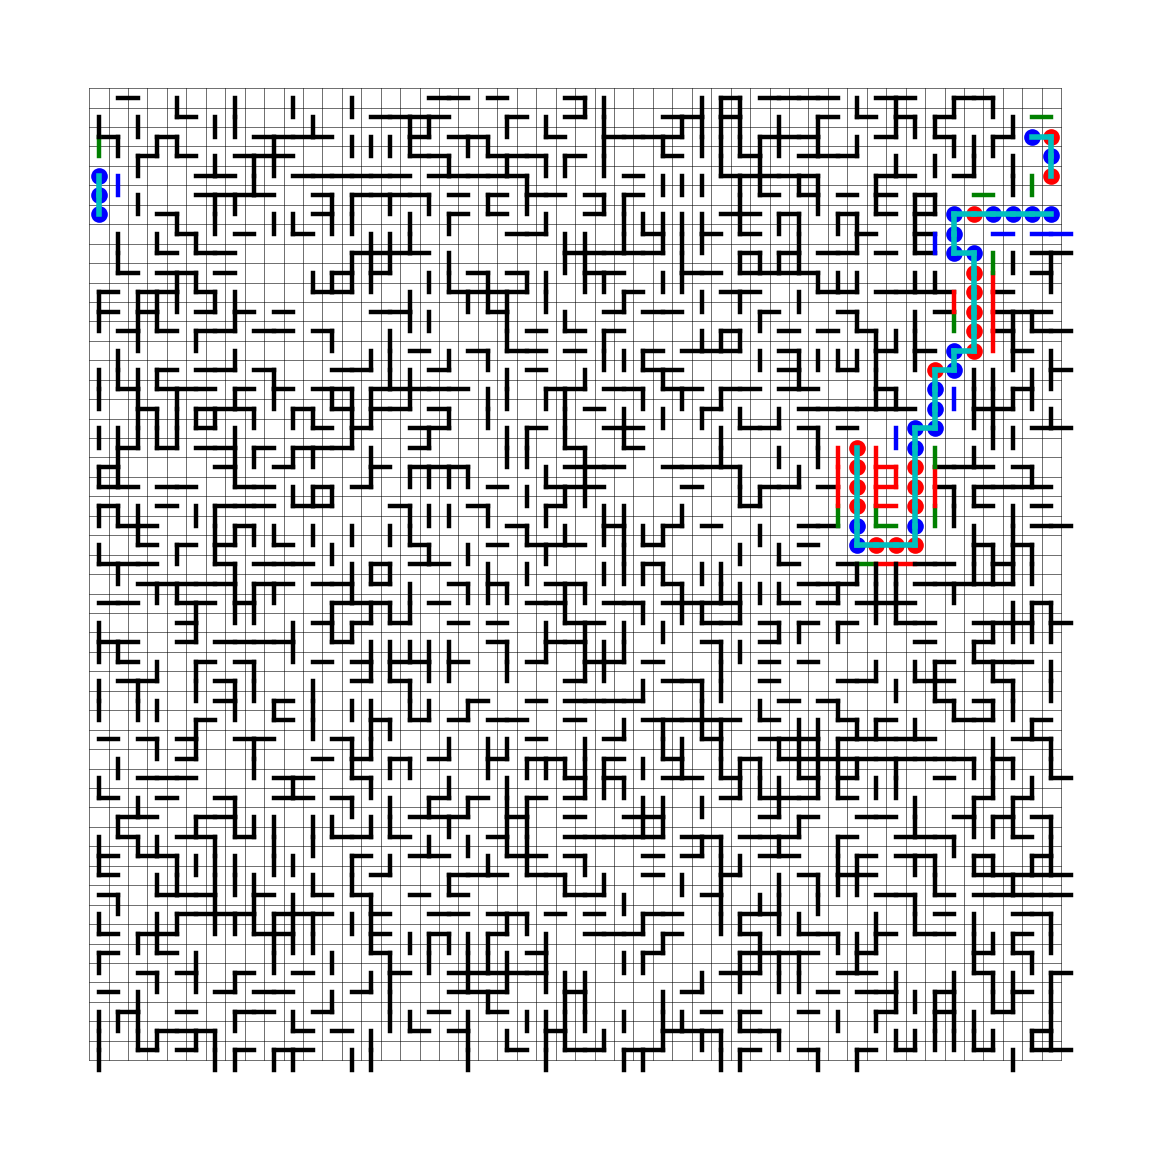

In [8]:
raw_conf_data=np.loadtxt(f"{path_working_directory:}/output_files/Protein_Configurations.dat",dtype=np.int32)
x_pos,y_pos,list_of_times=convert_raw_conf_data(raw_conf_data,n_proteins,n_monomers)

data_folding_labels = ["t","system energy","protein energy",
                    "system volume","$\#$ H bonds bulk","$\#$ H bonds PHO",
                    "$\#$ H bonds PHI","$\#$ H bonds mixed","$\#$ coop bonds",
                    "$\#$ coop bonds PHI","$\#$ PHO aa-water contacs","$\#$ PHI aa-water contacs"]


raw_data_folding=np.loadtxt(f"{path_working_directory:}/output_files/Data_folding.dat")


rx=np.loadtxt(f"{path_working_directory:}/output_files/rx.dat",dtype=np.int32)
ry=np.loadtxt(f"{path_working_directory:}/output_files/ry.dat",dtype=np.int32)
ver_HB=np.loadtxt(f"{path_working_directory:}/output_files/ver_HB.dat",dtype=np.int32)
hor_HB=np.loadtxt(f"{path_working_directory:}/output_files/hor_HB.dat",dtype=np.int32)


def plot_grid(ax,box_size):
    for i_line in range(box_size+1):
        ax.plot(i_line*np.array([1,1])+.5,np.array([0, box_size])+.5,'-k',linewidth=.1) 
        ax.plot(np.array([0, box_size])+.5,i_line*np.array([1,1])+.5,'-k',linewidth=.1)
        


i_prot=0

i_t=98
fig,ax=plt.subplots(figsize=(3,3))
ax.set_axis_off()
plot_grid(ax,box_size)
for i_mon in range(n_monomers):
    now_col='b'
    if aa_is_PHO[-aa_sequence_in_numbers[i_mon]-1]:
        now_col='r'

    ax.plot(x_pos[i_mon,i_prot,i_t],y_pos[i_mon,i_prot,i_t],'o',
            color=now_col,
            markersize=3,
            markeredgewidth=0.0)
for i_mon in range(n_monomers-1):
    dx=x_pos[i_mon+1,i_prot,i_t]-x_pos[i_mon,i_prot,i_t]
    dy=y_pos[i_mon+1,i_prot,i_t]-y_pos[i_mon,i_prot,i_t]
    if np.abs(dx)<=1 and np.abs(dy)<=1:
        ax.plot([x_pos[i_mon+1,i_prot,i_t],x_pos[i_mon,i_prot,i_t]],
                [y_pos[i_mon+1,i_prot,i_t],y_pos[i_mon,i_prot,i_t]],'-c',linewidth=1)
        
plot_HB(ax,hor_HB[i_t],ver_HB[i_t],rx,ry)

Text(0, 0.5, 'protein energy')

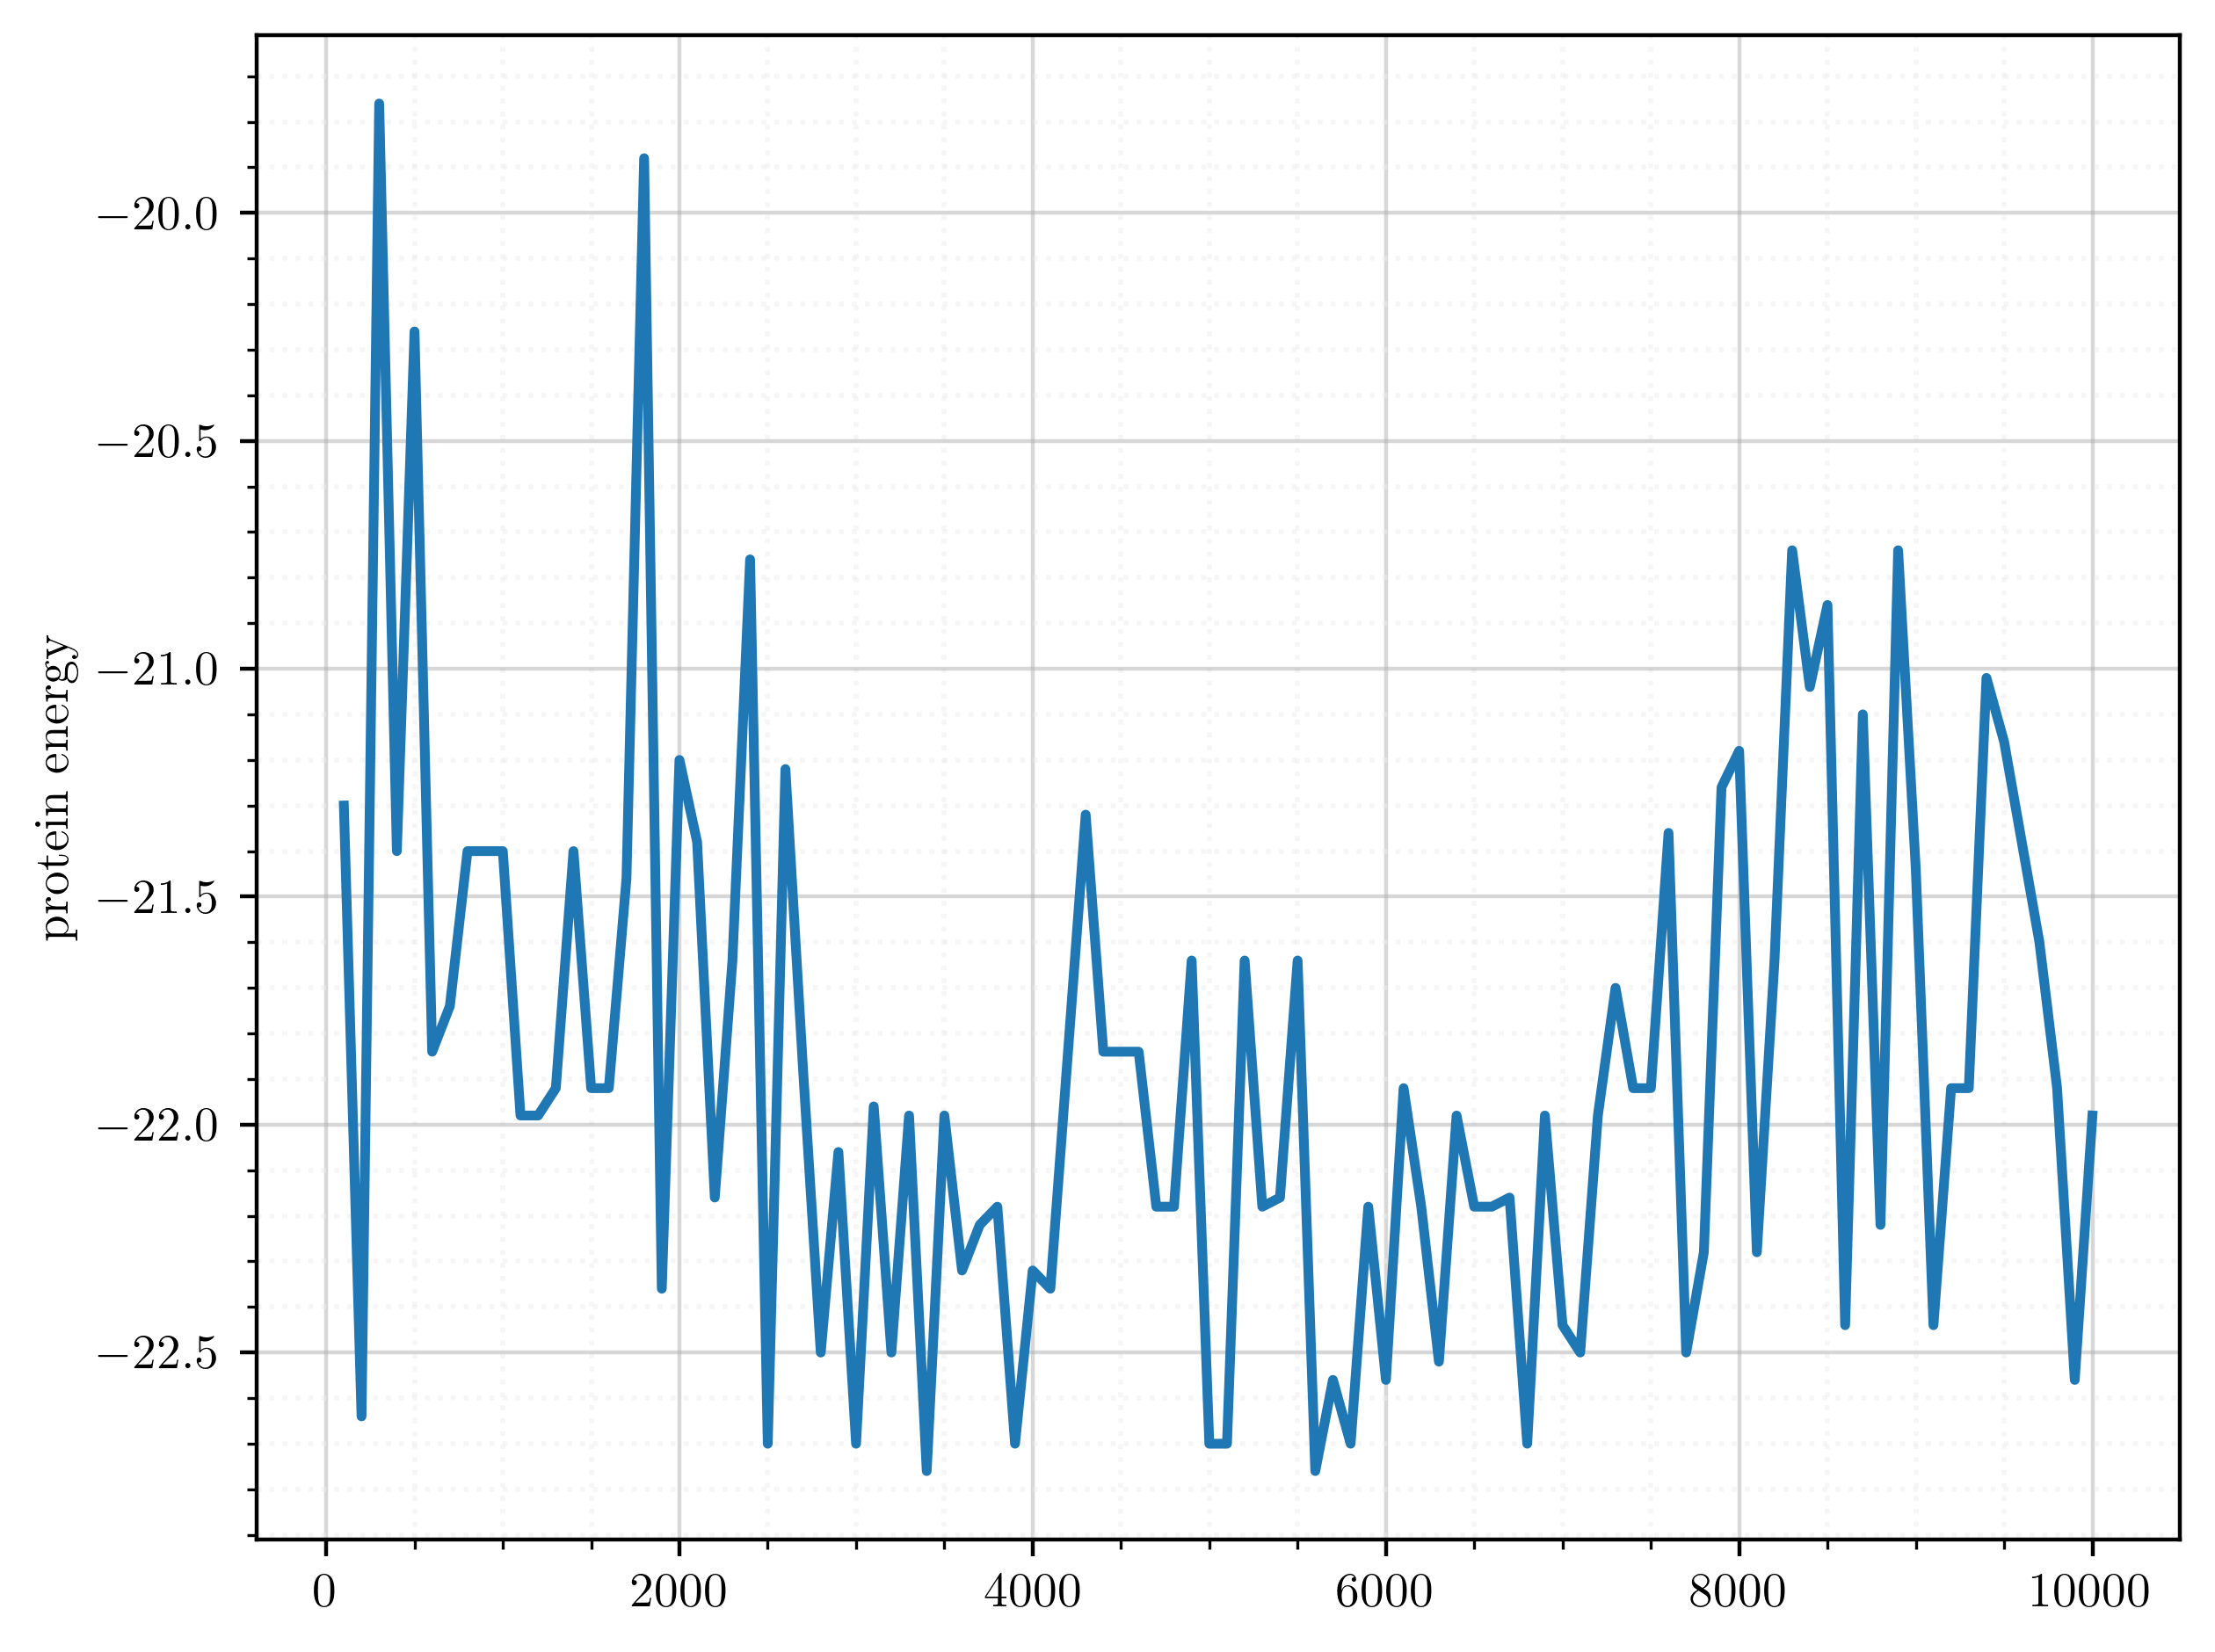

In [9]:
fig,ax=plt.subplots()
ax.grid(alpha=0.5, which='both')
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True)
ind_to_plot=2
ax.plot(raw_data_folding[:,0],raw_data_folding[:,ind_to_plot])
ax.set_ylabel(f"{data_folding_labels[ind_to_plot]:}")